In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import geopandas as gpd
import rasterio as rio

In [2]:
pwd

'C:\\Users\\musimundo\\Desktop\\coco_coding_homework-main\\coco_coding_homework-main\\coco_coding_homework\\GeoHackeo\\buenos_aires-master\\buenos_aires-master\\GeoHackeo'

# descripcion inicial del dataset
Este proyecto va a trabajar con un dataset de temperaturas minimas y maximas durante 365dias de todas las estaciones pertenecientes al Servicio Meteorologico Nacional Argentino. 
El objetivo es limpiar el dataset para quedarnos con 5 estaciones que generan un "perfil" desde zonas menos a mas urbanizadas.

In [80]:
# Importo los datos de temperatura
data_folder = Path(".") 
dataset_temperatura = pd.read_csv (data_folder / 'temperatura365d_todo.csv', sep= ";")

In [81]:
dataset_temperatura.head()

FECHA  TMAX  TMIN             NOMBRE
0         NaN   NaN   NaN                NaN
1  15032023.0  30.6  24.5    AEROPARQUE AERO
2  15032023.0  28.5  19.9          AZUL AERO
3  15032023.0  32.3  21.2  BAHIA BLANCA AERO
4  15032023.0  19.4  11.5     BARILOCHE AERO

A primera vista se observa que la columna fecha no esta en un formato aceptable, y que hay datos NaN, por lo que es necesario realizar algunos cambios en la columna fecha.
Es necesario:
1- eliminar la terminacion ".0"
2- no sabemos si las fechas que comienzan en dias de 1 digito digamos 9 de marzo de 2023 estan escritas como 09/03/2023 o 9/03/2023, es necesario corregir esto o estar seguro de que vamos a tener siempre 8 digitos en la fecha para una posterior conversion

In [86]:
# Para poder elimiar una parte de un dato, pandas sugiere trabajar con str, por lo que transformamos la columna FECHA en str
dataset_temperatura["FECHA"]= dataset_temperatura["FECHA"].astype(str)

In [87]:
# luego tomamos todos los datos de temperatura y les eliminamos los ultimos 2 digitos 
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.slice(stop=-2)

In [88]:
# para evitar posibles errores de formato, se utiliza zfill(), este codigo lo que hace es agregar 0 al inicio del dato
# hasta llegar a lenght= 8, en el caso de que el dato ya tenga 8 digitos, no hace nada.. el objetivo de esto es 
# que en el caso que existan fechas escritas como 9032023, la va a convertir a 09032023, y asi evitar futuros errores
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.zfill(8)

In [89]:
dataset_temperatura

FECHA  TMAX  TMIN                       NOMBRE
0      0000000n   NaN   NaN                          NaN
1      15032023  30.6  24.5              AEROPARQUE AERO
2      15032023  28.5  19.9                    AZUL AERO
3      15032023  32.3  21.2            BAHIA BLANCA AERO
4      15032023  19.4  11.5               BARILOCHE AERO
...         ...   ...   ...                          ...
44352  16032022  35.7  14.3                  VIEDMA AERO
44353  16032022  31.7  14.3  VILLA DE MARIA DEL RIO SECO
44354  16032022  34.3  19.2           VILLA DOLORES AERO
44355  16032022  30.3  10.4            VILLA GESELL AERO
44356  16032022  36.2   9.6          VILLA REYNOLDS AERO

[44357 rows x 4 columns]

Ahora el dataset tiene un formato mas aceptable, con todos los datos en la columna FECHA, normalizados. El siguiente paso es limpiar la base de datos, ya que se ve a simple vista que hay datos NaNs

In [90]:
# buscamos si hay datos null
dataset_temperatura.isnull()

FECHA   TMAX   TMIN  NOMBRE
0      False   True   True    True
1      False  False  False   False
2      False  False  False   False
3      False  False  False   False
4      False  False  False   False
...      ...    ...    ...     ...
44352  False  False  False   False
44353  False  False  False   False
44354  False  False  False   False
44355  False  False  False   False
44356  False  False  False   False

[44357 rows x 4 columns]

In [91]:
# eliminamos los datos null
dataset_temperatura = dataset_temperatura.dropna()

In [92]:
#buscamos datos duplicados
dataset_temperatura[dataset_temperatura.duplicated()]

Empty DataFrame
Columns: [FECHA, TMAX, TMIN, NOMBRE]
Index: []

In [93]:
dataset_temperatura.shape

(42165, 4)

Se han eliminado mas de 2000 filas que tenian datos NaN.
El siguiente paso es tranformar el dato en la columna FECHA en formato Fecha

In [94]:
# redefinimos la columna FECHA asignandole un formato, en este caso le decimos que los 2 primeros digitos son dia
# los digitos 3-4 son el mes y los ultimos 4 son el año 
dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')

C:\Users\musimundo\AppData\Local\Temp\ipykernel_24532\1840762363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')


In [95]:
# el codigo tira un error, pero luego cuando inscpeccionamos el dataset, vemos que la columna fecha fue formateada con exito
dataset_temperatura

FECHA  TMAX  TMIN                       NOMBRE
1     2023-03-15  30.6  24.5              AEROPARQUE AERO
2     2023-03-15  28.5  19.9                    AZUL AERO
3     2023-03-15  32.3  21.2            BAHIA BLANCA AERO
4     2023-03-15  19.4  11.5               BARILOCHE AERO
5     2023-03-15  -6.0 -13.7             BASE BELGRANO II
...          ...   ...   ...                          ...
44352 2022-03-16  35.7  14.3                  VIEDMA AERO
44353 2022-03-16  31.7  14.3  VILLA DE MARIA DEL RIO SECO
44354 2022-03-16  34.3  19.2           VILLA DOLORES AERO
44355 2022-03-16  30.3  10.4            VILLA GESELL AERO
44356 2022-03-16  36.2   9.6          VILLA REYNOLDS AERO

[42165 rows x 4 columns]

AEROPARQUE AERO
BUENOS AIRES
EL PALOMAR AERO
MORON AERO
MERLO AERO
NUEVE DE JULIO

In [96]:
#, dataset_temperatura['NOMBRE']== 'BUENOS AIRES'
#                     , dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MORON AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MERLO AERO'
  #                   , dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO')

In [97]:
filtro_aeroparque = dataset_temperatura['NOMBRE']== 'AEROPARQUE AERO' 
filtro_palomar = dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
filtro_moron = dataset_temperatura['NOMBRE']== 'MORON AERO'
filtro_9_julio = dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO'


In [98]:
#Alternativa
#rows = []
#for index, row in data.iterrows():
#    if row['NOMBRE'] == 'AEROPARQUE AERO' or row['NOMBRE'] == 'BUENOS AIRES OBSERVATORIO' or row['NOMBRE'] == 'EL PALOMAR AERO' or row['NOMBRE'] == 'BUENOS AIRES' or row['NOMBRE'] == 'MORON AERO' or row['NOMBRE'] == 'MERLO AERO' or row['NOMBRE'] == 'NUEVE DE JULIO' :
#        rows.append(row)
    

In [99]:
estaciones_target = (filtro_aeroparque + filtro_palomar  + filtro_moron
                + filtro_9_julio)
estaciones = dataset_temperatura[estaciones_target]

In [100]:
estaciones

FECHA  TMAX  TMIN           NOMBRE
1     2023-03-15  30.6  24.5  AEROPARQUE AERO
33    2023-03-15  30.8  24.2  EL PALOMAR AERO
64    2023-03-15  31.4  25.9       MORON AERO
66    2023-03-15  32.6  21.8   NUEVE DE JULIO
123   2023-03-14  35.1  27.4  AEROPARQUE AERO
...          ...   ...   ...              ...
44179 2022-03-17  30.8  15.6   NUEVE DE JULIO
44235 2022-03-16  27.6  19.8  AEROPARQUE AERO
44267 2022-03-16  28.9  15.0  EL PALOMAR AERO
44299 2022-03-16  28.8  19.5       MORON AERO
44301 2022-03-16  30.1  18.1   NUEVE DE JULIO

[1459 rows x 4 columns]

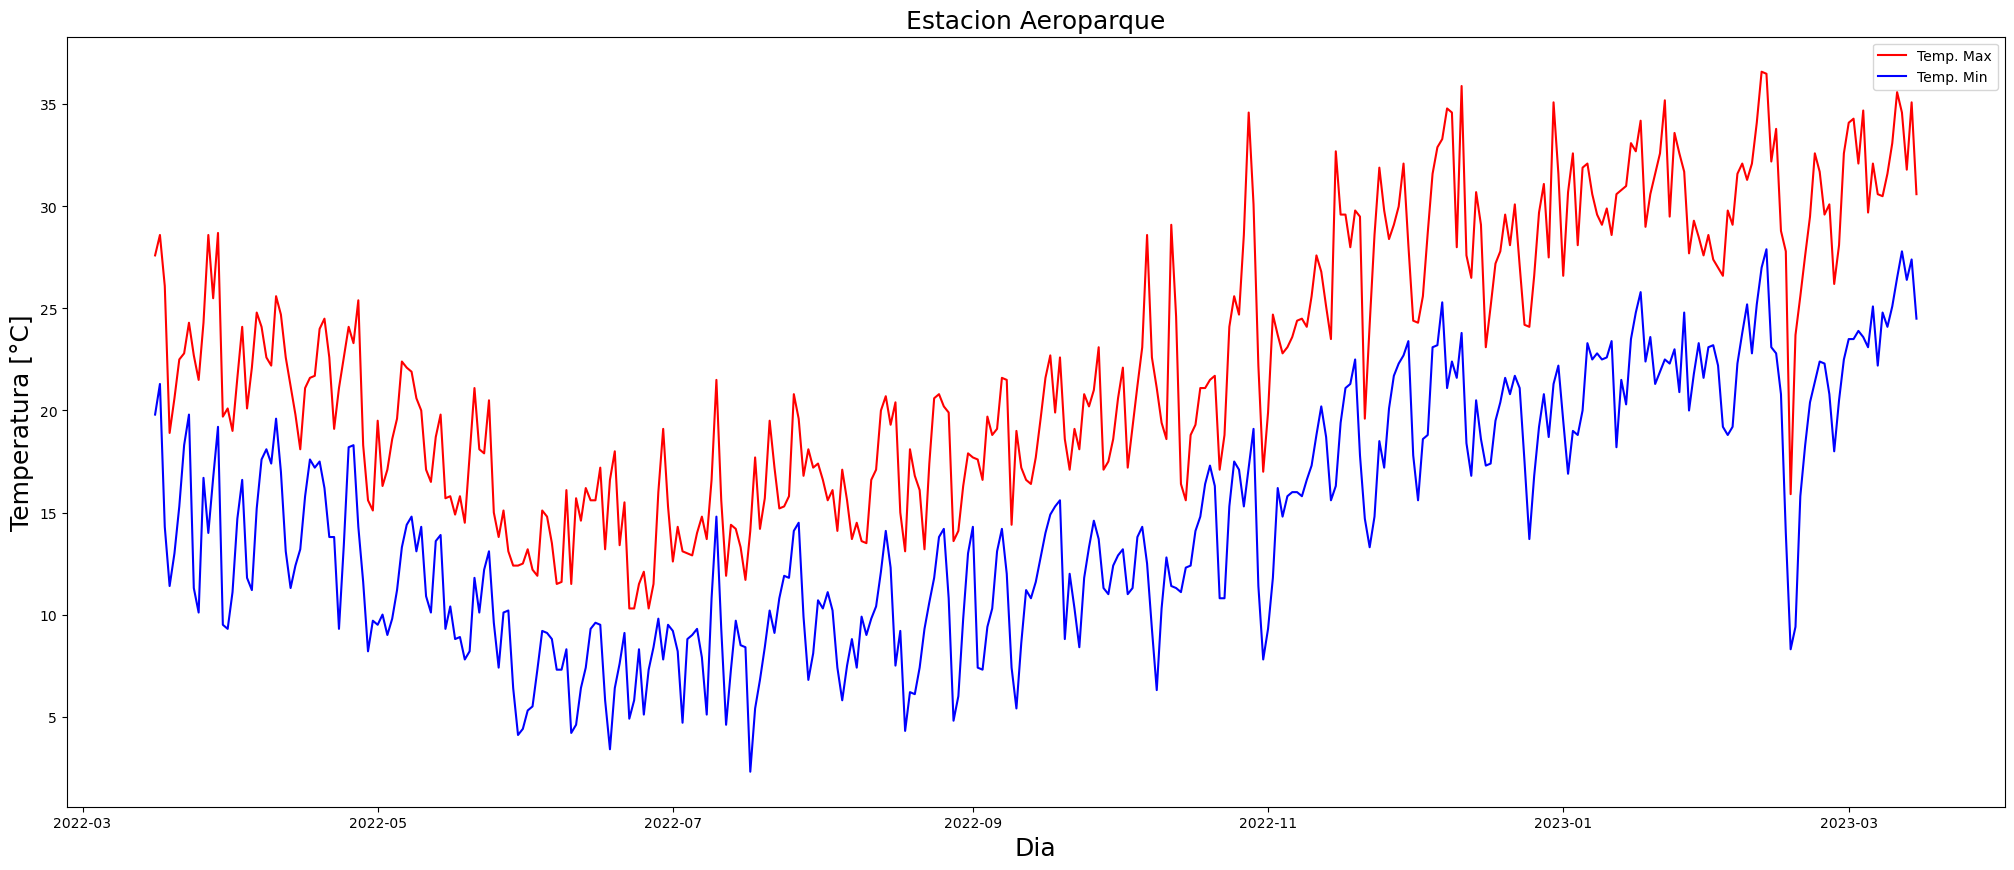

In [102]:
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")
plt.legend()
plt.ylabel('Temperatura [°C]',fontsize=18)
plt.xlabel('Dia',fontsize=18)
plt.title('Estacion Aeroparque',fontsize=18)
plt.show()

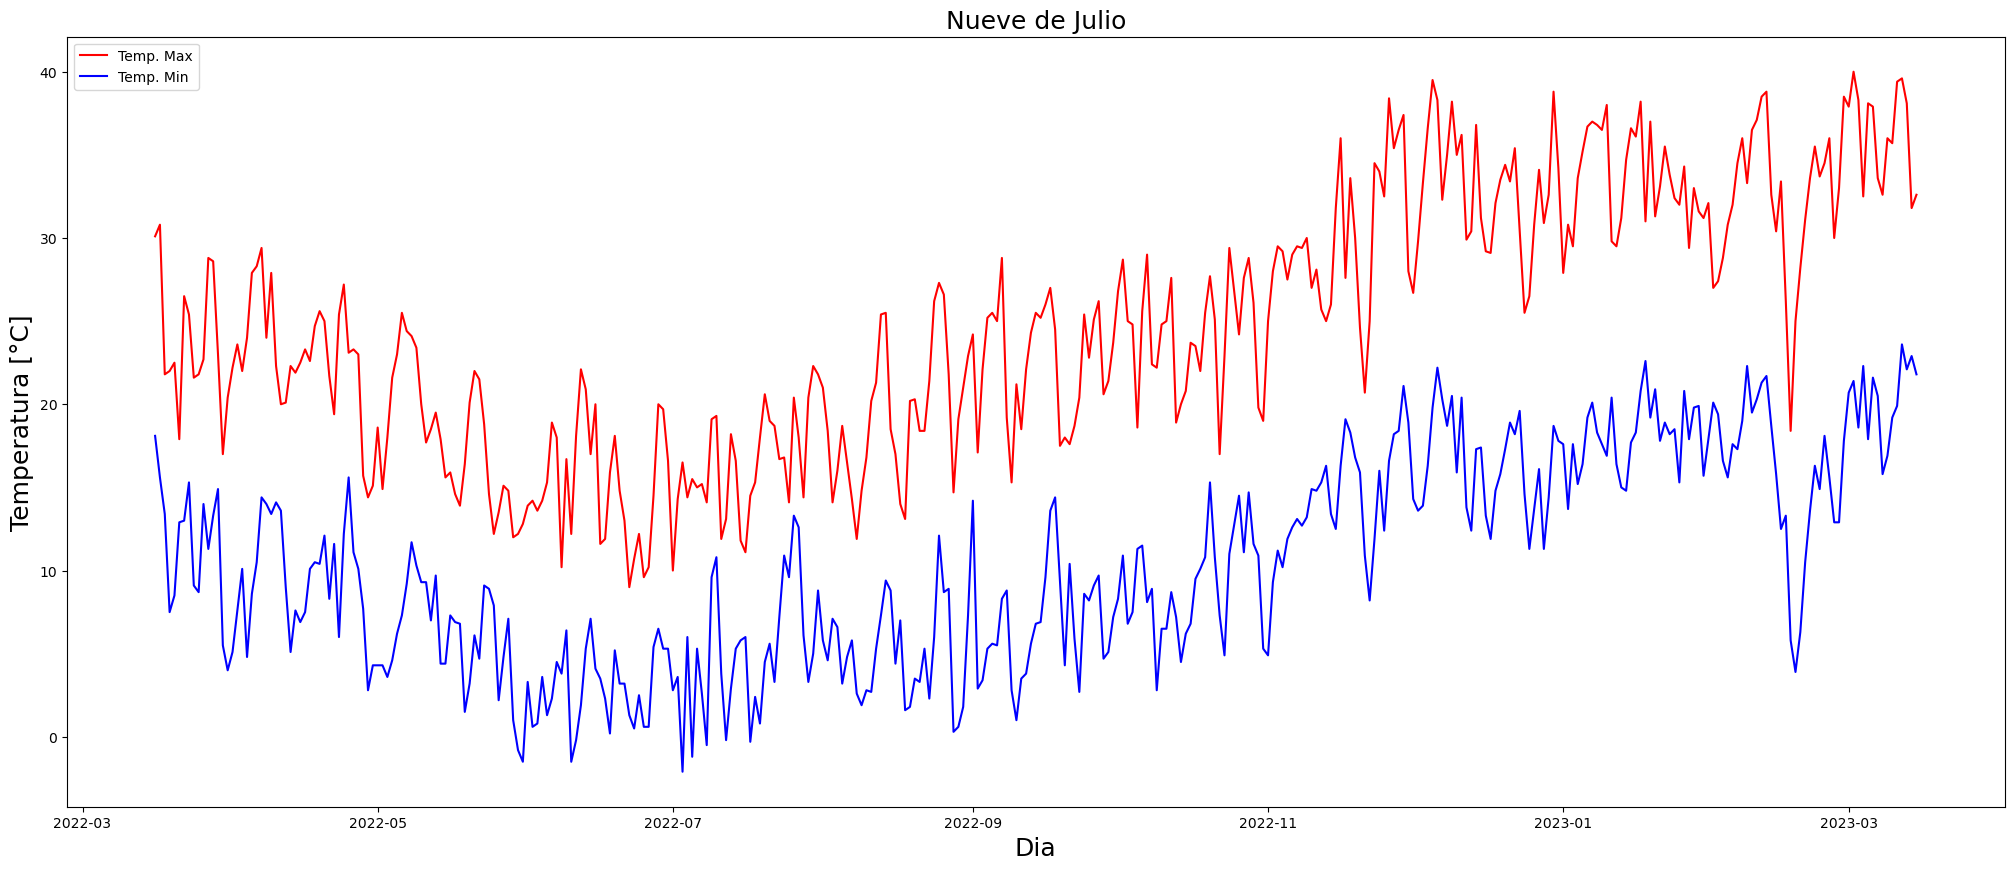

In [103]:
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")
plt.legend()
plt.ylabel('Temperatura [°C]',fontsize=18)
plt.xlabel('Dia',fontsize=18)
plt.title('Nueve de Julio',fontsize=18)
plt.show()

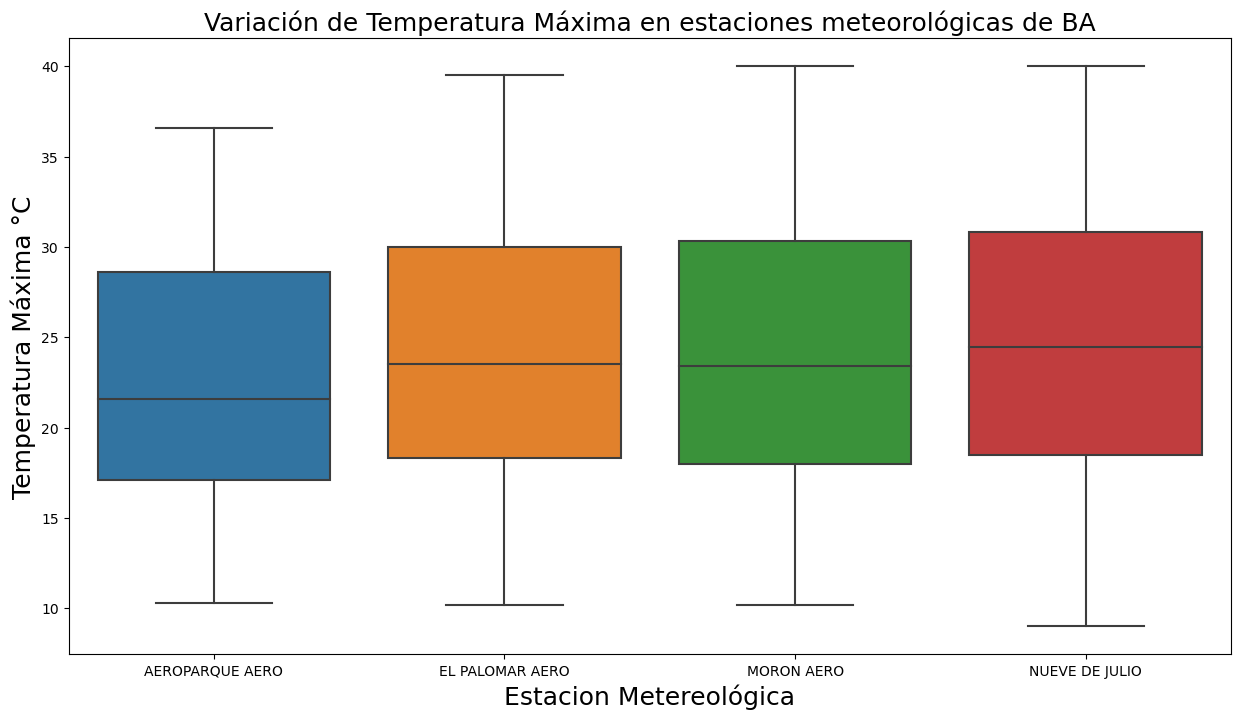

In [23]:
import seaborn as sns
plt.figure(figsize=(15,8))

ax = sns.boxplot(data= estaciones , x="NOMBRE", y="TMAX")
ax.set_title('Variación de Temperatura Máxima en estaciones meteorológicas de BA',fontdict={'size': 18})

ax.set_xlabel('Estacion Metereológica', fontdict={'size': 18})
ax.set_ylabel('Temperatura Máxima °C', fontdict={'size': 18})

plt.show()

In [59]:
# Importo los datos de temperatura
data_folder = Path(".") 
station1 = pd.read_csv (data_folder / 'station1_ave.csv', sep= ",")
station3 = pd.read_csv(data_folder /"station3_ave.csv", sep= ",")
station4 = pd.read_csv(data_folder /"station4_ave.csv", sep= ",")
station5 = pd.read_csv(data_folder /"station5_ave.csv", sep= ",")

In [60]:
print(station1)

       FECHA   TMAX   TMIN  TPROM           NOMBRE
0   Mar-2022  23.91  14.49  18.21  AEROPARQUE AERO
1   Abr-2022  21.76  14.51  18.13  AEROPARQUE AERO
2   May-2022  17.31  10.35  13.83  AEROPARQUE AERO
3   Jun-2022  13.98   7.28  10.63  AEROPARQUE AERO
4   Jul-2022  15.55   8.92  12.24  AEROPARQUE AERO
5   Ago-2022  16.70   9.38  13.04  AEROPARQUE AERO
6   Set-2022  19.05  11.44  15.25  AEROPARQUE AERO
7   Oct-2022  22.12  13.14  17.63  AEROPARQUE AERO
8   Nov-2022  26.68  17.67  22.17  AEROPARQUE AERO
9   Dec-2022  28.90  19.86  24.38  AEROPARQUE AERO
10  Ene-2023  30.65  21.87  26.26  AEROPARQUE AERO
11  Feb-2023  29.64  20.63  25.14  AEROPARQUE AERO
12  Mar-2023  32.70  24.77  28.73  AEROPARQUE AERO


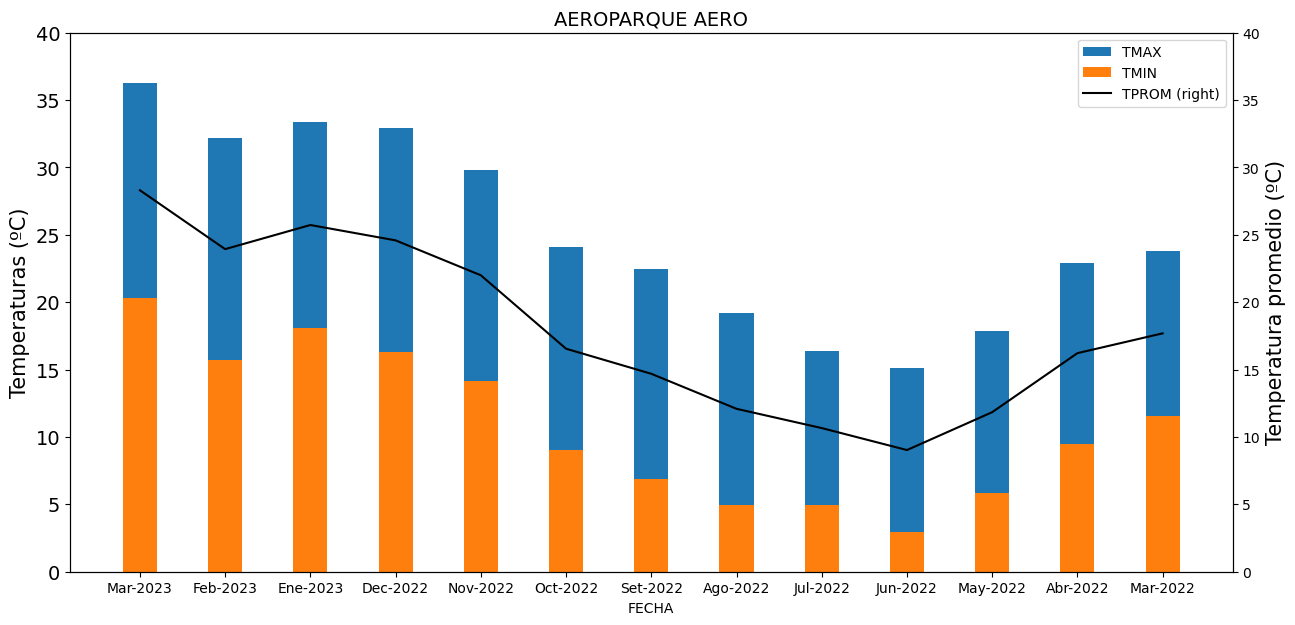

In [69]:
station5
fig, ax=plt.subplots()
X= station5['FECHA']
TMAX = station5['TMAX']
TMIN = station5['TMIN']

#X_axis = np.arange(len(X))

plt.bar(X, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X, TMIN, 0.4, label = 'TMIN')
#plt.xticks(X_axis, X, size= 14), plt.gca().invert_xaxis()
plt.ylabel('Temperaturas (ºC)', size=15), plt.legend(fontsize=15)
plt.yticks(fontsize = 14)

station5.plot(x ='FECHA', y='TPROM', ax = ax, secondary_y = True, color='Black', figsize=(15,7)),
ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=15),
plt.title("AEROPARQUE AERO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station1_bars.png", dpi=300)
plt.show()

In [71]:
data_folder = Path(".") 
provincia = gpd.read_file (data_folder / 'provincia_buenos_aires.shp')

In [73]:
estaciones = pd.read_csv (data_folder / 'estaciones_smn.csv', sep= ";")

In [74]:
provincia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [75]:
estaciones.head()

Nombre     lat   long
0      AEROPARQUE AERO -34.560 -58.41
1      EL PALOMAR AERO -34.600 -58.61
2           MORON AERO -34.601 -58.63
3  NUEVE DE JULIO AERO -35.430 -60.88

In [83]:
lat = estaciones.lat
lon = estaciones.long
est = estaciones.Nombre

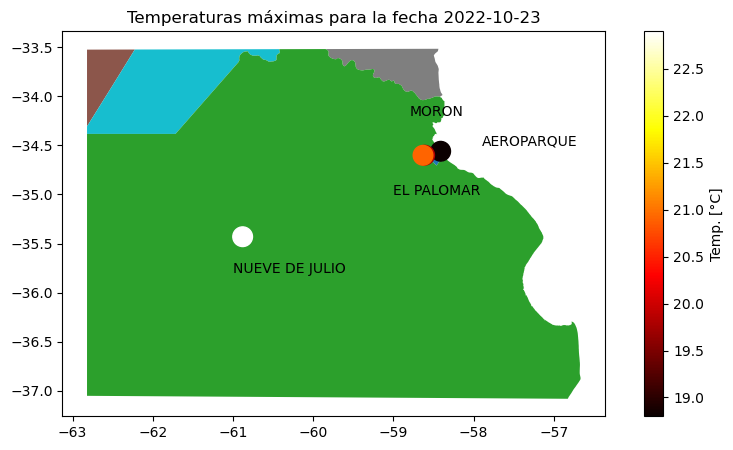

In [110]:
dia = "2022-10-23"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

provincia.plot(column='FNA', linewidth = 4)#, alpha= 0.5)#linecolor= 'b')
plt.scatter(lon,lat,
          c=tmax,s=200,
          cmap='hot', alpha=1)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(-61,-35.8, "NUEVE DE JULIO")
plt.text(-59,-35, "EL PALOMAR")
plt.text(-58.8,-34.2, "MORON")
plt.text(-57.9,-34.5, "AEROPARQUE")
plt.title("Temperaturas máximas para la fecha " + dia)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

## seccion II

In [111]:
import xarray as xr
import geopandas as gpd
import os

import planetary_computer 
import pystac_client
import odc.stac

import matplotlib.pyplot as plt

import numpy as np

import rasterio.features

from pathlib import Path


In [112]:
bbox_of_interest = [-61.07,-35.62 , -58.15 , -34.31 ]

time_of_interest = "2023-01-01/2023-03-01"

In [113]:
os.environ['PC_SDK_SUBSCRIPTION_KEY'] = '2bb1ce5c4d8944d48b4129b9215ef932'  
# Always set this when reading from URLs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 26 Items


In [114]:
ds = odc.stac.stac_load(
    items, 
    bands = ["nir08", "red"],
    bbox=bbox_of_interest,
    crs="utm",
    resolution=250, # units of output CRS (UTM)
    groupby='year', # adjacent acquisition frames automatically merged
    chunks={}, # Use Dask library to divy up large dataset!
)

In [115]:
ds

<xarray.Dataset>
Dimensions:      (y: 610, x: 1083, time: 1)
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>

In [116]:
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)

ndvi

<xarray.DataArray (time: 1, y: 610, x: 1083)>
dask.array<truediv, shape=(1, 610, 1083), dtype=float64, chunksize=(1, 610, 1083), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449

In [117]:
ndvi = ndvi.compute()

C:\Users\musimundo\anaconda3\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


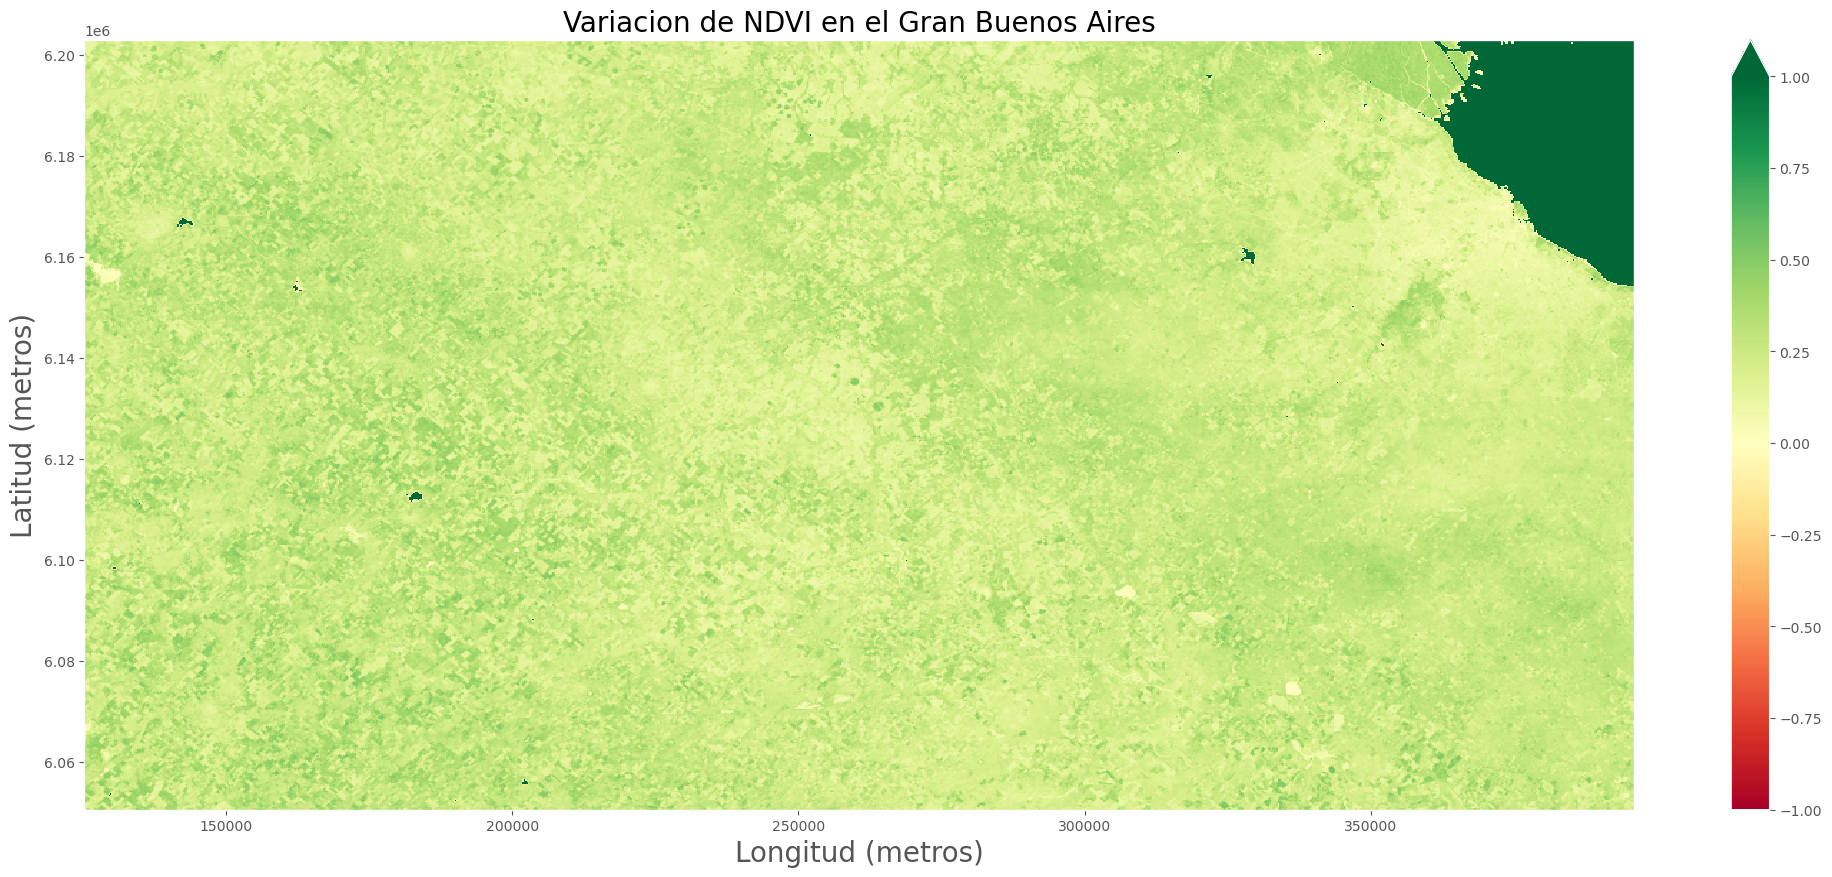

In [83]:
ndvi.isel(time=slice(0,1)).plot(vmin=-1, vmax=1, cmap='RdYlGn', label = "NDVI");
plt.xlabel('Longitud (metros)',fontsize=20)
plt.ylabel('Latitud (metros)',fontsize=20)
plt.title("Variacion de NDVI en el Gran Buenos Aires",fontsize=20)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()


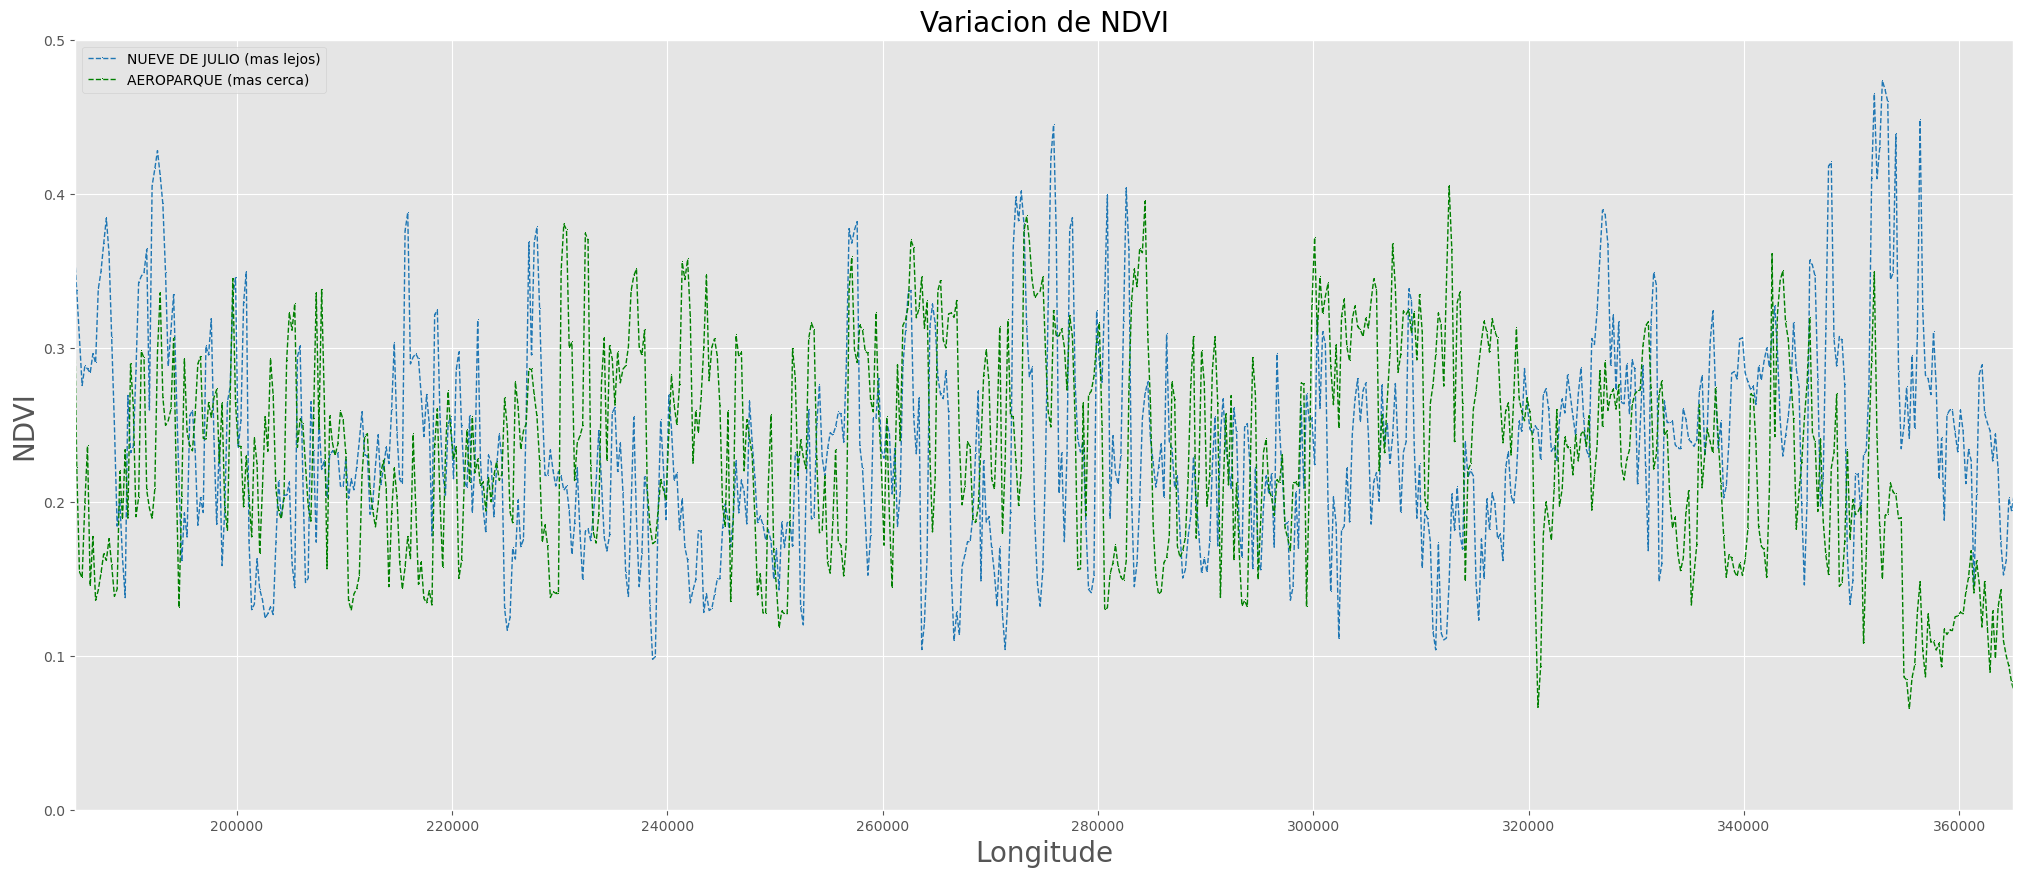

In [86]:
# Extract a profile (best in UTM for x-axis in meters)
plt.style.use('ggplot')
ndvi.sel(y=6080000, method='nearest').plot(color='#1f77b4', marker=',', linestyle='dashed',
     linewidth=1, markersize=25,label="NUEVE DE JULIO (mas lejos)")
ndvi.sel(y=6170000, method='nearest').plot(color='green', marker=',', linestyle='dashed',
     linewidth=1, markersize=25, label= "AEROPARQUE (mas cerca)")
plt.ylim(0, 0.5)
plt.xlim(185000, 365000)
plt.legend()
plt.xlabel('Longitude',fontsize=20)
plt.ylabel('NDVI',fontsize=20)
plt.title("Variacion de NDVI",fontsize=20)
plt.rcParams["figure.figsize"] = (25,10)
plt.show()

In [91]:
ndvi = Path(".") / "ndvi.tif"

In [92]:
ndvi = xr.open_dataarray(
    ndvi, 
    engine='rasterio',
)

ndvi

<xarray.DataArray 'band_data' (band: 1, y: 610, x: 1083)>
[660630 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

In [119]:
estaciones2 = pd.read_csv (data_folder / 'estaciones_utm.csv', sep= ";")

In [120]:
estaciones2

Nombre       x        y
0      AEROPARQUE AERO  375000  6170000
1      EL PALOMAR AERO  350000  6160000
2           MORON AERO  355000  6160000
3  NUEVE DE JULIO AERO  175000  6080000

In [121]:
lat = estaciones2.x
lon = estaciones2.y
est = estaciones2.Nombre

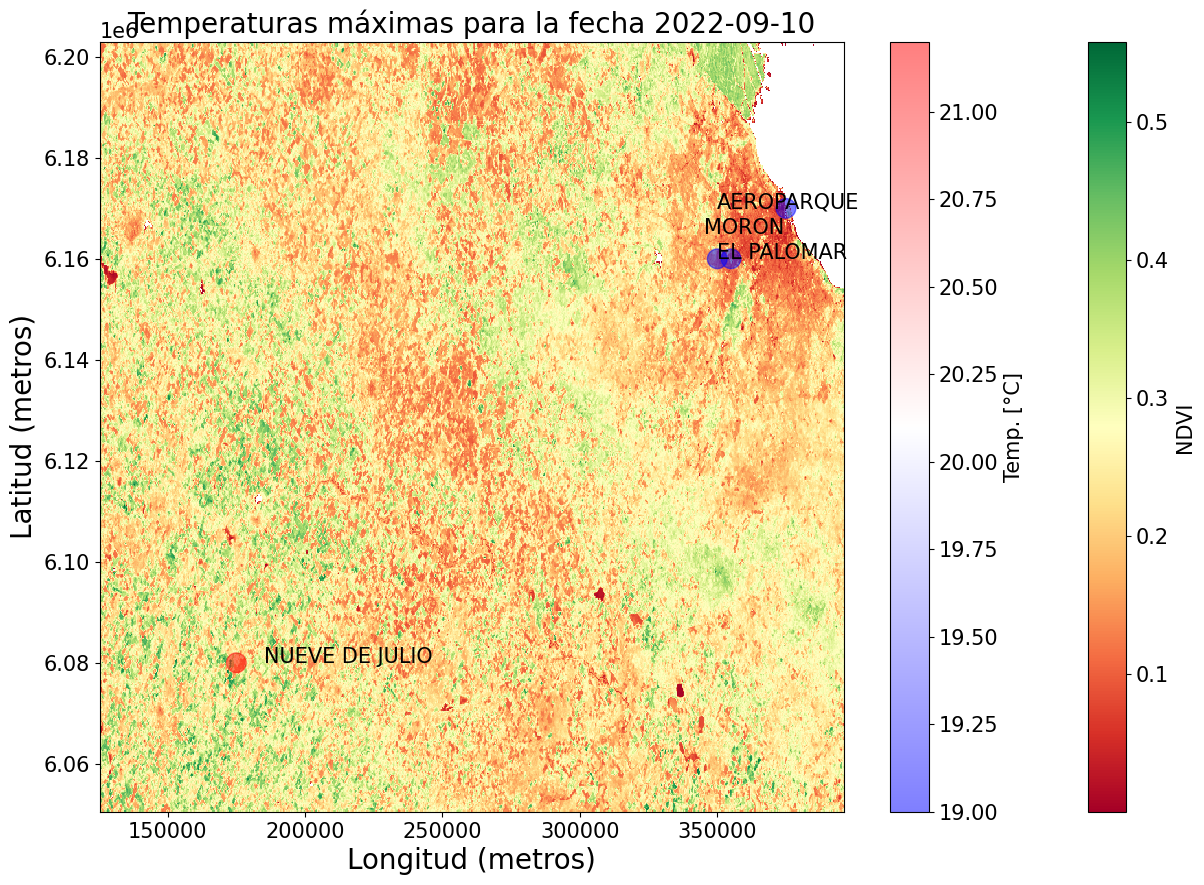

In [137]:
dia = "2022-09-10"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

ndvi.where(ndvi<1.01).squeeze().plot(cbar_kwargs={'label': "NDVI"},cmap="RdYlGn")

ax = plt.scatter(lat,lon,
          c=tmax,s=200,
          cmap='bwr', alpha=0.5)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(185000,6080000, "NUEVE DE JULIO",  fontsize=15)
plt.text(350000,6160000, "EL PALOMAR",fontsize=15)
plt.text(345000,6165000, "MORON",fontsize=15)
plt.text(350000, 6170000, "AEROPARQUE",fontsize=15)
plt.title("Temperaturas máximas para la fecha " + dia, fontsize=20 )
plt.xlabel('Longitud (metros)',fontsize=20)
plt.ylabel('Latitud (metros)',fontsize=20)
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})
plt.show()



In [129]:
tmax

22609    19.0
22641    19.0
22672    19.0
22674    21.2
Name: TMAX, dtype: float64

In [130]:
estaciones2

Nombre       x        y
0      AEROPARQUE AERO  375000  6170000
1      EL PALOMAR AERO  350000  6160000
2           MORON AERO  355000  6160000
3  NUEVE DE JULIO AERO  175000  6080000